In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from adjustText import adjust_text
from statsmodels.stats.multitest import fdrcorrection, multipletests
import matplotlib.colors as mcolors
from gseapy import barplot, dotplot
import gseapy as gp

In [2]:
model = '/Users/connormullins/Excel sheets/Model.csv'
osm = '/Users/connormullins/Excel sheets/OmicsSomaticMutations.csv'
effect = '/Users/connormullins/Excel sheets/CRISPRGeneEffect.csv'

In [3]:
model_df = pd.read_csv(model, header=0, index_col=0)
osm_df = pd.read_csv(osm, header=0, low_memory=False)
effect_df = pd.read_csv(effect, header=0, index_col=0)

In [4]:
cancer_type = "Non-Small Cell Lung Cancer"
protein = "KRAS"
gene_change = "p.Q61H"

In [5]:
#filter to get only mutated genes
cancer_filter = model_df[model_df["OncotreePrimaryDisease"] == cancer_type]
osm_filter_pie = cancer_filter.merge(osm_df, on=['ModelID'], how='inner')
protein_filter = osm_filter_pie[(osm_filter_pie['HugoSymbol'] == protein)]
protein_change_filter = protein_filter[(protein_filter['ProteinChange']== gene_change)]
osm_filter_pie.set_index('ModelID')
protein_change_filter = protein_change_filter.filter(['ModelID'])

In [6]:
#retrieve wt cell lines-- have cancer but not gene mutation specified
# concat ModelIDs of protein_filter and osm_df-- drop duplicates of osm_df and keep first, then drop duplicates with protein_filter
osm_df = osm_df.filter(['ModelID'])
osm_df = osm_df.drop_duplicates(keep = 'first')
protein_filter = protein_filter.filter(['ModelID'])
wt_and_mutant = pd.concat([protein_filter, osm_df])
wt_gene = wt_and_mutant.drop_duplicates(keep = False)

In [7]:
effect_mutant = protein_change_filter.merge(effect_df, on = ['ModelID'], how = 'inner')
effect_mutant = effect_mutant.set_index('ModelID')

effect_wt = wt_gene.merge(effect_df, on = ['ModelID'], how = 'inner')
effect_wt = effect_wt.set_index('ModelID')

In [8]:
_, p_value = scipy.stats.ttest_ind(effect_mutant, effect_wt)

In [10]:
pvalue_df = pd.DataFrame(p_value)
pvalue_df = pvalue_df.set_index(effect_df.columns)
pvalue_df = pvalue_df.rename(columns = {0 : 'p-value'})

#use mean gene effect to rank
pvalue_df['mean gene effect'] = abs(effect_mutant.mean(axis = 0))

In [11]:
sig_pv = pvalue_df[pvalue_df['p-value'] < 0.05]
sig_pv = sig_pv.reset_index()
sig_pv = sig_pv.sort_values('mean gene effect', ascending=False).head(300)
sig_pv['gene name'] = sig_pv['index'].apply(lambda x: x.split(' ')[0])

In [12]:
gene_df = pd.DataFrame()
gene_df['gene'] = sig_pv['gene name']

In [16]:
gmt = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.v2024.1.Hs.symbols.gmt')

In [17]:
enr = gp.enrichr(gene_df, gmt, outdir = 'test')

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


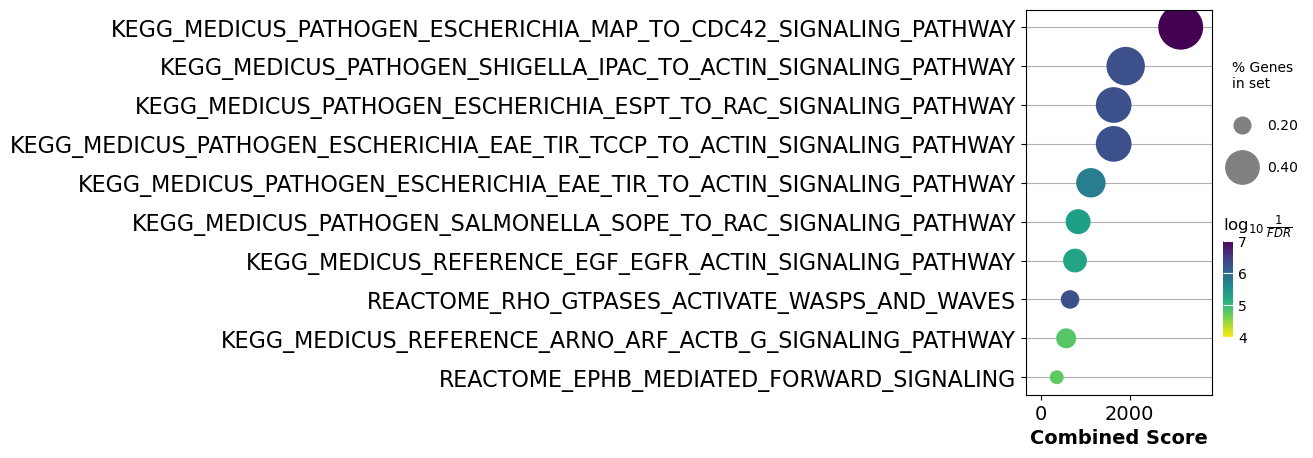

In [18]:
ax = dotplot(enr.res2d, title='',cmap='viridis_r', size=10, figsize=(3,5))

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


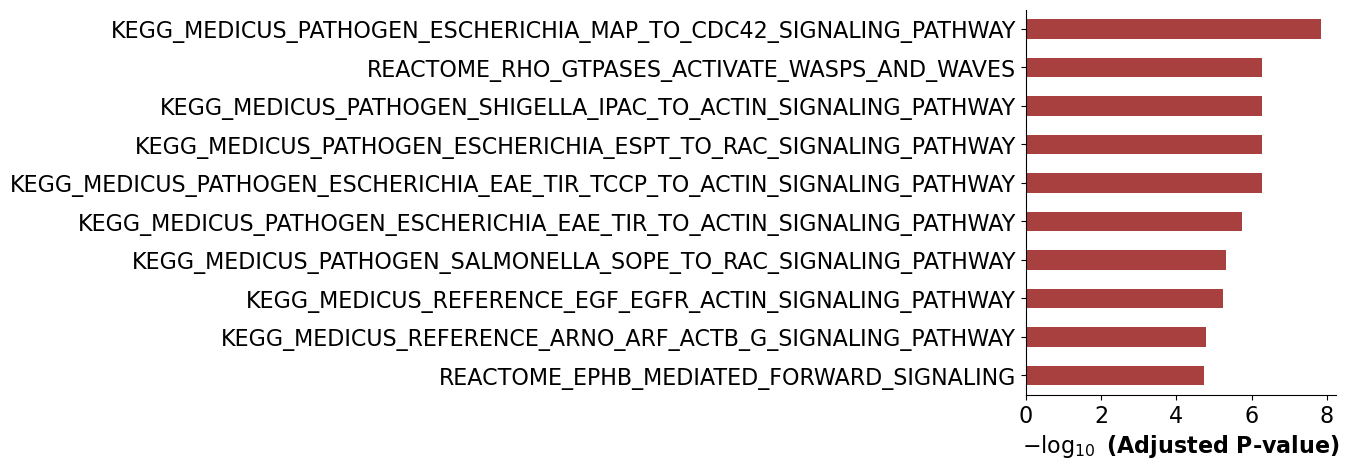

In [19]:
ax = barplot(enr.res2d,title='', figsize=(4, 5), color='darkred')